# Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

### Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, 
которая будет считать retention игроков (по дням от даты регистрации игрока).

##### Для начала посмотрим на данные, с которыми нам предстоит работать, проведем разведочный анализ, проверим целостность и типы.

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import requests
from urllib.parse import urlencode

import scipy.stats as ss
import pingouin as pg

%matplotlib inline

OUTDATED_RAISE_EXCEPTION=1
OUTDATED_IGNORE=1 

In [35]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv',sep = ';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv',sep = ';')

In [36]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [37]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [38]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [39]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [40]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [41]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


##### В данных по два столбца с id пользователей и датами регистрации и авторизации, пропущенных значений в данных нет. Для дальнейшей работы приведем дату к формату datetime и объеденим таблицы по id.

In [42]:
reg_data['reg_ts'] = pd.to_datetime(reg_data.reg_ts, unit='s').dt.date
auth_data['auth_ts'] = pd.to_datetime(auth_data.auth_ts, unit='s').dt.date

In [43]:
all_data = reg_data.merge(auth_data, on='uid')
all_data.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [44]:
all_data.dtypes

reg_ts     object
uid         int64
auth_ts    object
dtype: object

In [45]:
all_data.shape[0]

9601013

In [46]:
all_data.uid.nunique()

1000000

In [47]:
all_data.reg_ts.min()

datetime.date(1998, 11, 18)

In [48]:
all_data.reg_ts.max()

datetime.date(2020, 9, 23)

##### В нашем датасете мы получили 9 601 013 записей от 1 000 000 пользователей с датами регистрации с 18.11.1998 по 23.09.2020 

##### Так как объем данных слишком большой, я думаю для бизнеса наиболее интересно будет узнать более свежую информацию по retention, поэтому мы возьмем данные за последний месяц, относительно даты последней регистрации 23.09.2020 .

В функцию retention передаем следующие аргументы:
- data - данные, из которых будем извлекать нужные значения
- start_date - дата, с которой начинается нужный нам период в формате "год-месяц-день"
- period - количество исследуемых дней

In [49]:
def retention(data, start_date, period):
    
    start_date = pd.to_datetime(start_date)
    end_date = start_date + pd.DateOffset(days=period)
    
    # Отбираем нужный нам срез данных по начальной и конечной дате, учитывая заданный период:
    period_data = data.query('reg_ts >= @start_date & reg_ts <= @end_date')     
    
    # Считаем количество вошедших пользователей для каждой когорты:
    cohort_df = period_data.groupby(['reg_ts', 'auth_ts'], as_index=False) \
                        .agg({'uid': 'nunique'}) \
                        .sort_values(['reg_ts', 'auth_ts'], ascending=[True, True]) \
                        .rename(columns=({'uid': 'quantity_uniq_auth'}))
    
    # Считаем количество зарегистрированных пользователей для каждой когорты, расчитываем retention и количество дней, 
    # прошедших со дня регистрации для каждой когорты:
    cohort_df['quantity_uniq_reg'] = cohort_df.groupby(['reg_ts'])['quantity_uniq_auth'].transform('max')
    cohort_df['retention'] = 100 * (cohort_df['quantity_uniq_auth']/cohort_df['quantity_uniq_reg'])
    cohort_df['days'] = (cohort_df['auth_ts'] - cohort_df['reg_ts']).dt.days
    
    # Cоздаем сводную таблицу, заменив отсутствующие значения на ноль и исключая нулевой день, где retention равен 100%:
    pivot_table = cohort_df.query('days > 0').pivot(index='reg_ts',columns='days',values='retention').fillna(0)
    
    # По полученной таблице строим тепловую карту со значениями, округленными до 2-х знаков после запятой:
    plt.figure(figsize=(20, 16))
    sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='Oranges')
    plt.title('Retention')
    plt.ylabel('Когорта')
    plt.xlabel('День')
    fig=plt.show()
    fig
    return fig

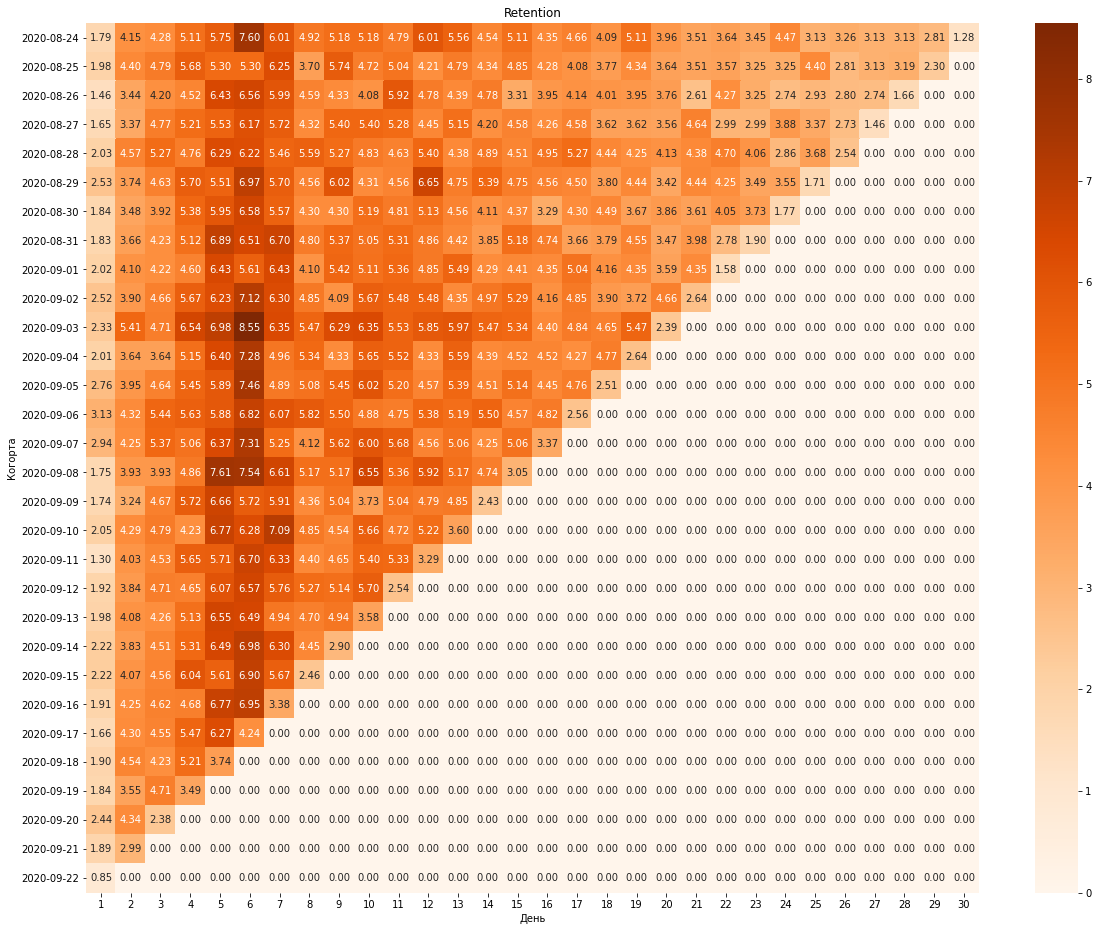

In [50]:
retention_data = retention(all_data, '2020-08-24', 30)
retention_data

### Вывод:
##### По полученной таблице можно сделать вывод, что минимальный Retention наблюдается на следующий день после регистрации, после чего начинает расти до пиковых значений на 5-7 день, далее он постепенно снижается.

## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [51]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

In [52]:
# Скачаем данные с Yandex Disk
def read_csv_from_yandex_disk(base_url, public_key):
    download_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(download_url)
    download_url = response.json()['href']
    return pd.read_csv(download_url, sep=';')

In [53]:
revenue_data = read_csv_from_yandex_disk(base_url, public_key)

##### Для начала посмотрим на данные, с которыми нам предстоит работать, проведем разведочный анализ, проверим целостность и типы.

In [54]:
revenue_data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [55]:
revenue_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [56]:
revenue_data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

##### По предварительному анализу данных можно отметить, что данные заполнены хорошо, пропущенные значения отсутствуют.

In [57]:
revenue_data.testgroup.unique()

array(['b', 'a'], dtype=object)

In [58]:
revenue_data.query('testgroup == "a"').describe().round(2)

,user_id,revenue
count,202103.00,202103.00
mean,202555.91,25.41
std,116802.33,920.77
min,2.00,0.00
25%,101502.50,0.00
50%,202988.00,0.00
75%,303559.00,0.00
max,404769.00,37433.00


In [59]:
revenue_data.query('testgroup == "b"').describe().round(2)

,user_id,revenue
count,202667.00,202667.00
mean,202215.56,26.75
std,116891.93,287.32
min,1.00,0.00
25%,100855.50,0.00
50%,201821.00,0.00
75%,303602.50,0.00
max,404770.00,4000.00


##### В группе "a" 202 103 пользователей, а в группе "b" 202 667.
##### Максимальная прибыль в группе "а" больше чем в "b" примернов 9 раз, при этом среднее значение группы "а" меньше чем в "b" 

##### Следует посмотреть чем отличается доход по группам пользователей и на нормальность распределение в каждой из выборок.

In [60]:
# Платящие пользователи по группам
pay_users_by_gr = revenue_data.query('revenue != 0').groupby('testgroup', as_index = False).agg({'user_id':'count'}) \
                .rename(columns={'user_id': 'pay_users'})
pay_users_by_gr

,testgroup,pay_users
0,a,1928
1,b,1805


##### Действительно, как и говорилось в задании, в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

### Контрольная группа

In [61]:
control_gr = revenue_data.query('testgroup=="a"')

In [62]:
control_gr_pay = revenue_data.query('testgroup=="a" and revenue != 0')
control_gr_pay.describe().round(2)

,user_id,revenue
count,1928.00,1928.00
mean,200152.68,2664.00
std,116596.50,9049.04
min,73.00,200.00
25%,99323.00,257.00
50%,199854.50,311.00
75%,299664.25,361.00
max,404768.00,37433.00


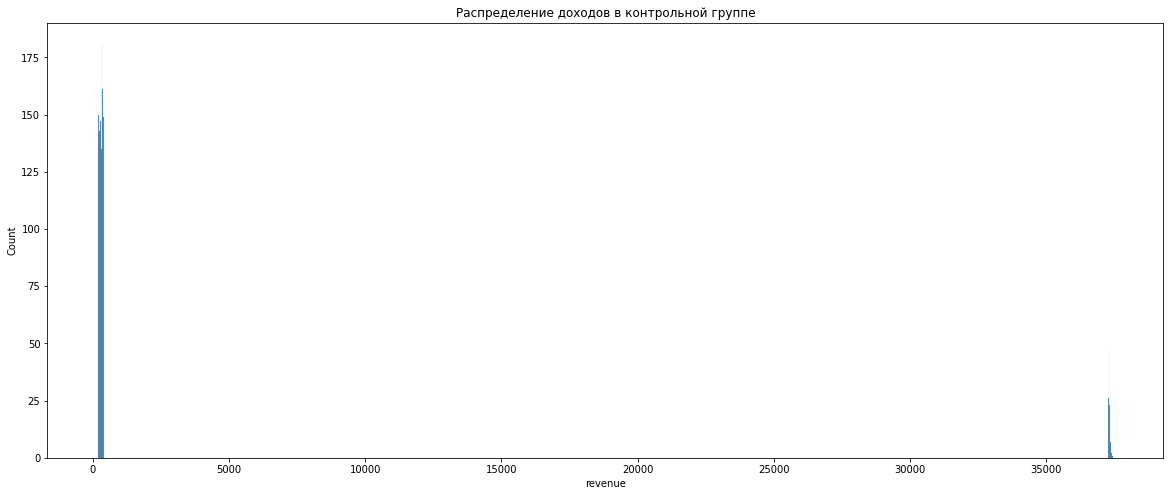

In [63]:
plt.figure(figsize=(20, 8))
plt.title('Распределение доходов в контрольной группе')
sns.histplot(x='revenue', data=control_gr_pay)

##### По графику видно, что есть некоторое количество выбросов, которые влияют на общую картину

##### Посмотрим на график без выбросов и посчитаем сколько их и какую долю от общего дохода они приносят:

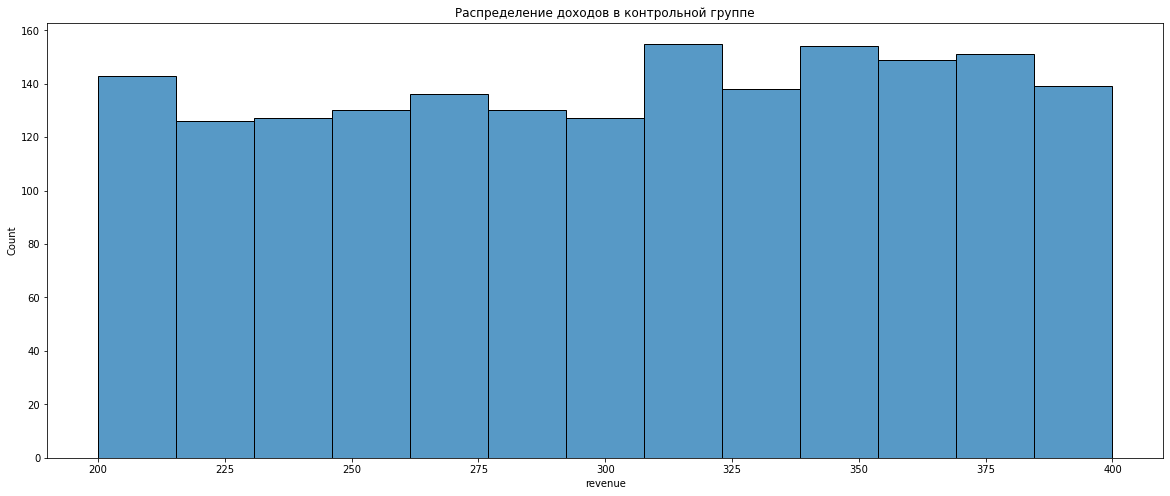

In [64]:
plt.figure(figsize=(20, 8))
plt.title('Распределение доходов в контрольной группе')
sns.histplot(x='revenue', data=control_gr_pay.query('revenue < 5000'))

In [65]:
control_gr_pay.query('revenue > 5000').shape[0]

123

In [66]:
round(control_gr_pay.query('revenue >= 5000').revenue.sum() / control_gr_pay.revenue.sum() * 100, 1)

89.4

In [67]:
round(control_gr_pay.query('revenue >= 5000').user_id.count() / control_gr_pay.user_id.count() * 100, 1)

6.4

##### Таким образом выбросами считаются 123 пользователя, которые составляют 6.4% от всех пользователей, но что еще более важно они приносят 89.4% от общего дохода, поэтому не учитывать их в дальнейших расчетах мы не можем.

### Тестовая группа

In [68]:
test_gr = revenue_data.query('testgroup=="b"')

In [69]:
test_gr_pay = revenue_data.query('testgroup=="b" and revenue != 0')
test_gr_pay.describe().round(2)

,user_id,revenue
count,1805.00,1805.00
mean,205834.55,3003.66
std,116400.05,572.62
min,161.00,2000.00
25%,106815.00,2513.00
50%,206651.00,3022.00
75%,304907.00,3478.00
max,404526.00,4000.00


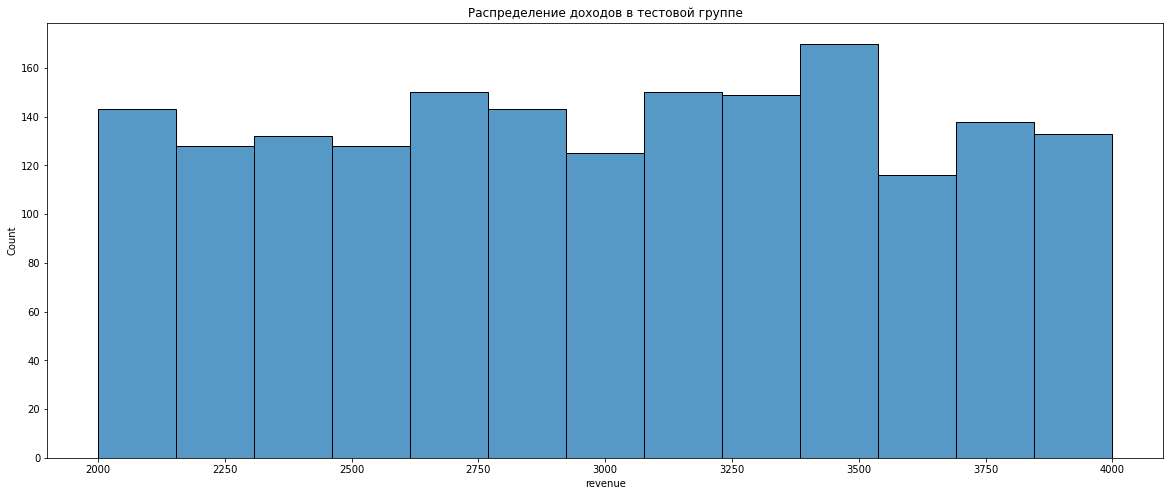

In [70]:
plt.figure(figsize=(20, 8))
plt.title('Распределение доходов в тестовой группе')
sns.histplot(x='revenue', data=test_gr_pay)

##### По графику можно сделать вывод, что в данной группе выбросов нет и все revenue находятся в диапазоне от 2000 до 4000, данные на первый взгляд распределены ненормально.

##### Наблюдаются странные различия в двух выборках:
- В Контрольной группе имеется 123 выброса с revenue выше 35000, остальные значения находятся в диапазоне от 200 до 400.
- В тестовой же группе выбросов нет и все значения находятся в диапазоне от 2000 до 4000.
##### Возможно были неправильно сформированы группы.

##### Тем не менее имея на руках только данные о сумме покупки и пренадлежности к одной из групп, сравним эти группы по трем показателям: 
- ARPU (Average Revenue Per User или Средний Доход с Пользователя)
- ARPPU (Average Revenue Per Paying User или Средний доход с платящего пользователя) 
- CR (Conversion Rate или доля платящих пользователей среди всех пользователей)

### 1. ARPU

#### Гипотезы: 
- H0 - ARPU между группами не различаются
- H1 - ARPU между группами различаются

Чтобы определить какой тест будем использовать необходимо проверить группы на однородность дисперсии (по тесту Леви) и нормальность распределения (по тесту Шапиро - Уилка).

In [71]:
pg.homoscedasticity(data=revenue_data, dv='revenue', group='testgroup')

,W,pval,equal_var
levene,0.389629,0.532495,True


In [72]:
pg.normality(control_gr.revenue, method="normaltest")

,W,pval,normal
revenue,585152.731273,0.0,False


In [73]:
pg.normality(test_gr.revenue, method="normaltest")

,W,pval,normal
revenue,326622.395409,0.0,False


##### Несмотря на то что распределение ненормально, наша выборка достаточно велика и дисперсность однородна, поэтому мы можем использовать t-test для проверки гипотез.

In [74]:
pg.ttest(control_gr.revenue.values, test_gr.revenue.values, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.624203,404768,two-sided,0.532495,"[-5.54, 2.86]",0.001962,0.004,0.095694


### Вывод по сравнению ARPU:
#### p-value > 0.05 (0.533), поэтому мы оставляем нулевую гипотезу о том, что средние доходы от всех пользователей в двух группах статзначимо не различаются 

### 2. ARPPU

#### Гипотезы: 
- H0 - ARPPU между группами не различаются
- H1 - ARPPU между группами различаются

Аналогично проверим группы с платящими пользователями на однородность дисперсии (по тесту Леви) и нормальность распределения (по тесту Шапиро - Уилка).

In [75]:
pg.homoscedasticity(data=revenue_data.query('revenue != 0'), dv='revenue', group='testgroup')

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


In [76]:
pg.normality(control_gr_pay.revenue, method="normaltest")

,W,pval,normal
revenue,1394.945784,1.234161e-303,False


In [77]:
pg.normality(test_gr_pay.revenue, method="normaltest")

,W,pval,normal
revenue,1068.860008,7.943249e-233,False


##### Так как распределение ненормально и дисперсность неоднородна, но наша выборка достаточно велика, мы по прежнему можем использовать t-test для проверки гипотез с порправкой на критерий Уэлча

In [78]:
pg.ttest(control_gr_pay.revenue.values, test_gr_pay.revenue.values, correction=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.64463,1943.481522,two-sided,0.100208,"[-744.7, 65.38]",0.052132,0.142,0.356381


### Вывод по сравнению ARPPU:
#### p-value > 0.05 (0.1), поэтому мы оставляем нулевую гипотезу о том, что средние доходы от платящих пользователей в двух группах статзначимо не различаются 

### 3. CR

#### Гипотезы:
- H0 - Конверсия между группами не различается
- H1 - Конверсия между группами различна

##### Создадим столбик buy и присвоим '1' платящим пользователям и '0' неплатящим.
##### Задав категориальные переменные, для сравнения конверсий двух групп будем использовать тест Хи-квадрат

In [79]:
revenue_data['buy'] = revenue_data['revenue'].apply(lambda x: 1 if x>0 else 0)

In [80]:
ss.chi2_contingency(pd.crosstab(revenue_data['testgroup'], revenue_data['buy']))

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[200239.10075104,   1863.89924896],
        [200797.89924896,   1869.10075104]]))

In [81]:
conv_data = revenue_data.groupby('testgroup',as_index = False).agg({'user_id': 'count', 'buy': 'sum'}) \
            .rename(columns={'user_id': 'users', 'buy': 'buyers'})
conv_data['conversion'] = round(conv_data['buyers'] / conv_data['users'] * 100, 2)
conv_data

,testgroup,users,buyers,conversion
0,a,202103,1928,0.95
1,b,202667,1805,0.89


### Вывод по сравнению CR:
#### p-value < 0.05 (0.0365), поэтому мы отвергаем нулевую гипотезу, доля платящих пользователей в двух группах статзначимо различается (в тестовой группе меньше)

## Общий вывод:

#### ARPU и ARPPU в двух группах отличаются не значимо, при этом конверсия в покупку в тестовой и контрольной группе значимо отличаются — в тестовой она меньше. 
#### Исходя из этого можно сказать, что тест оказался неудачным, тестовые предложения лучше не вводить
#### Также можно проверить правильность деления пользователей на группы , по причине слишком разных распределений revenue

## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Метрики для оценки результатов события: 


#### Метрики продукта (игры):
- Количество полученных бонусов (наград)
- Среднее количество пройденных уровней на 1 игрока до/после события
- Совокупное время в мин/сек, проведенное пользователем в игре до/после события
- Среднее время прохождения каждого уровня

#### Метрики роста клиентской аудитории:
- MAU - количество уникальных игроков, которые зашли в игру в течение месяца
- DAU - количество уникальных игроков, которые зашли в игру в течение суток
- Retention Rate - процент возврата игроков на платформу во время события.
- Churn Rate - процент оттока после проведения события, в течение какого-то кол-ва дней.
- New Users — кол-во новых игроков, зарегистрировавшихся во время события.

#### Метрики доходов/расходов
- ARPPU (Average Revenue Per Paying User) — средний доход от одного платящего пользователя до/после события
- ARPU (Average Revenue Per User) - средний доход с привлеченного пользователя до/после события
- CR (Conversion rate) - процент пользователей, совершивших покупку или оформивших подписку (предполагаем, что есть подписка или платные бонусы в игре) за время события.
- Маржинальность игры – разница между полученными доходами и расходами до/после события

#### Я думаю, что набор метрик при усложнении механики событий в целом не изменится, но за этими метриками я бы более пристально понаблюдал:
- Churn Rate
- Retention Rate
- Совокупное время, проведенное пользователем в игре
- Среднее время прохождения каждого уровня.